# Module 3 Final Project

<strong>Name:</strong> Allie Kelly<br>
<strong>Pace:</strong> Part-time<br>
<strong>Project Review: </strong><br>
<strong>Instructor:</strong> Victor Geislinger<br>
<strong>Blog Post URL:</strong>

## Import Packages and Data

In [1]:
import sqlite3
import scipy
import scipy.stats as stats
import statsmodels as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

import math
import numpy as np
import pandas as pd

In [2]:
#begin SQL cursor, import data
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

# Hypothesis 1

$H_{0}$ The average product order quantity is equal whether a discount is applied or not.<br>
   
$H_{1}$ The average product order quantity increases when a discount is applied as compared to the average quantity when a discount is not applied. <Br>
    
This is a one-tailed t-test.

In [3]:
#Transform SQL data into DataFrame for the relevant table
cur.execute("""Select * FROM OrderDetail;""")
order_df= pd.DataFrame(cur.fetchall())
order_df.columns = [x[0] for x in cur.description]
order_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


## EDA for Hypothesis 1

In [4]:
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [5]:
order_df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


My immediate impression of the data is that there are 2155 orders that were made and kept in this table. There are 77 different products, and the discounts range from none to 25%.  

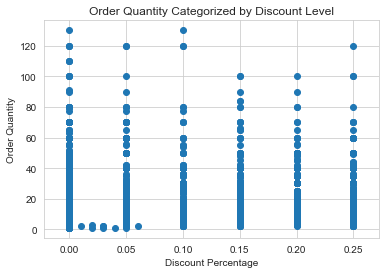

In [6]:
plt.scatter(order_df.Discount, order_df.Quantity)
plt.title("Order Quantity Categorized by Discount Level")
plt.xlabel("Discount Percentage")
plt.ylabel("Order Quantity");

The scatter plot shows that its pretty evenly distributed among each discount level, though there are a few smaller dicounts that only have a few orders. 

/Users/Allie/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


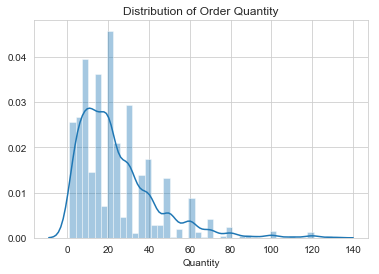

In [7]:
#Checking the distribution of order quantity
sns.distplot(order_df.Quantity)
plt.title("Distribution of Order Quantity");

/Users/Allie/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


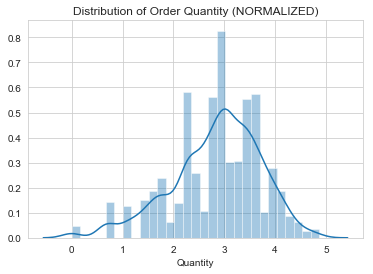

In [8]:
#Fulfilling the assumption that the data follows a normal distribution
sns.distplot(order_df.Quantity.apply(np.log))
plt.title(f"Distribution of Order Quantity (NORMALIZED)");

The distribution of order quantity is relatively normal, though a bit skewed to the right. 

In [9]:
len(order_df.OrderId.unique()) #There are 830 different orders made, multiple products per order

830

In [10]:
order_discount_pivot = pd.pivot_table(order_df, 
                                      index="Discount", 
                                      
                                      columns='ProductId', 
                                      values="Quantity",
                                      fill_value=0.0, 
                                      margins=True)

In [11]:
order_discount_pivot

ProductId,1,2,3,4,5,6,7,8,9,10,...,69,70,71,72,73,74,75,76,77,All
Discount,,,,,,,,,,,,,,,,,,,,,
0.0,17.772727,21.473684,28.800000,17.20,29.333333,26.750000,29.904762,30,4.5,19.454545,...,18.500000,19.043478,21.800000,19.677419,22.125000,22.600000,21.758621,22.730769,17.869565,21.715262
0.01,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000
0.02,0.000000,0.000000,0.000000,0.00,0.000000,1.000000,0.000000,0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
0.03,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.666667
0.04,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
0.05,20.000000,16.666667,0.000000,50.00,0.000000,33.000000,13.000000,0,0.0,20.000000,...,31.666667,21.000000,30.000000,20.000000,24.000000,0.000000,70.000000,33.000000,38.200000,28.010811
0.06,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
0.1,10.000000,20.000000,20.000000,22.50,15.000000,0.000000,20.000000,2,20.0,19.000000,...,21.333333,26.750000,24.500000,26.333333,20.000000,0.000000,20.600000,30.000000,24.000000,25.236994
0.15,19.600000,25.000000,0.000000,50.00,0.000000,0.000000,26.500000,15,16.0,49.333333,...,20.000000,29.000000,20.000000,27.500000,25.000000,20.000000,13.000000,27.000000,15.000000,28.382166


This pivot table shows the average order quantity of each product based on discount. From afar, it does look more or less like the quantity increases based on discount level. First however, we'll test whether having a discount affects quantity in general. 

In [12]:
# Splitting DataFrame based on whether or not the order had a discount 
no_discount = order_df.query('Discount == 0.0')
yes_discount = order_df.query('Discount > 0.0')

In [13]:
print(f'Number of orders with a discount: {len(yes_discount)}')
print(f'Average order quantity on orders with discount applied: {round(yes_discount.Quantity.mean(),2)}')

print(f'Number of orders without a discount: {len(no_discount)}')
print(f'Average order quantity on orders without discount applied: {round(no_discount.Quantity.mean(),2)}')


Number of orders with a discount: 838
Average order quantity on orders with discount applied: 27.11
Number of orders without a discount: 1317
Average order quantity on orders without discount applied: 21.72


## One-tailed T-Test

In [14]:
alpha = .05 
results = stats.ttest_ind(yes_discount.Quantity, no_discount.Quantity, equal_var=False)
one_tailed_p = results[1]

In [15]:
if one_tailed_p < alpha:
    print(f'With a p-value of {one_tailed_p}, we can safely reject the null hypothesis.')
else:
    print('We cannot reject the null hypothesis.')

With a p-value of 5.65641429030433e-10, we can safely reject the null hypothesis.


In [16]:
#Replace all discounts 6% or below with a 5% discount level because there are so few orders at those levels.
to_replace = [.01, .02, .03, .04, .06]
value = [.05, .05, .05, .05, .05]#if values to replace is a list, value MUST be the same length
order_df.Discount.replace(to_replace=to_replace, value=value, inplace=True)

## Calculate Effect Size of Discount with Cohen's D

Cohen's D will tell us the discount that has the highest effect on order quantity. 

In [17]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [18]:
discounts = [0.05, 0.1, 0.15, 0.2, 0.25]

for discount in discounts: 
    experiment = yes_discount.loc[yes_discount['Discount'] == discount].Quantity
    control = no_discount.Quantity
    cd = Cohen_d(experiment, control)
    print(f'The effect size of a {discount * 100} percent discount is {round(cd, 3)}')

The effect size of a 5.0 percent discount is 0.347
The effect size of a 10.0 percent discount is 0.196
The effect size of a 15.0 percent discount is 0.372
The effect size of a 20.0 percent discount is 0.301
The effect size of a 25.0 percent discount is 0.367


The discount with the highest effect size is 15%, followed closely by a 25% discount. 

# Hypothesis 2

$H_{0}$ The day of the week has no effect on order quantity. <br> 
$H_{1}$ The day of the week will cause a difference in order quantity. 
<br><br>
This two-tailed t-test that aims to predict which items are most likely to be ordered (or not ordered) on certain days which would help mitigate any stock issues that could arise from under- or over-ordering. 

In [19]:
cur.execute("""Select od.ProductId, od.Quantity, o.OrderDate
               FROM OrderDetail AS od
               JOIN 'Order' as o
               ON o.Id = od.OrderID;""")
order_df = pd.DataFrame(cur.fetchall()) 
order_df.columns = [i[0] for i in cur.description]
order_df.head()

,ProductId,Quantity,OrderDate
0,11,12,2012-07-04
1,42,10,2012-07-04
2,72,5,2012-07-04
3,14,9,2012-07-05
4,51,40,2012-07-05


In [20]:
#Adding a column that shows what day of the week the order was made
order_df['OrderDate'] = pd.to_datetime(order_df.OrderDate)
order_df['day_of_week'] = order_df['OrderDate'].dt.day_name()

In [21]:
order_df.head()

,ProductId,Quantity,OrderDate,day_of_week
0,11,12,2012-07-04,Wednesday
1,42,10,2012-07-04,Wednesday
2,72,5,2012-07-04,Wednesday
3,14,9,2012-07-05,Thursday
4,51,40,2012-07-05,Thursday


In [22]:
# Normalizing Data
order_df.Quantity = order_df.Quantity.apply(np.log)

In [23]:
weekday_quantity_pivot = pd.pivot_table(order_df, 
                                      index="ProductId", 
                                      columns='day_of_week', 
                                      values="Quantity",
                                      fill_value=0.0, 
                                      margins=True)
weekday_quantity_pivot.head()

day_of_week,Monday,Sunday,Thursday,Tuesday,Wednesday,All
ProductId,,,,,,
1,2.858345,2.530896,2.786384,3.188748,2.595236,2.752432
2,2.389001,2.882278,3.183746,3.088090,3.361936,2.927838
3,2.995732,3.176210,3.443776,2.594408,0.000000,3.060314
4,2.652773,2.925201,3.733686,1.445186,3.154876,2.835876
5,2.995732,2.596478,3.180584,3.585060,0.000000,3.126173


This pivot table shows the average order quantity per product per day of the week, with the last column showing average order quantities across all days of the week. The following process will demonstrate which days have significantly higher or lower order quantities as compared to the average order for that product.

In [24]:
#Making a dataframe from the pivot table
weekday_quantity = pd.DataFrame(weekday_quantity_pivot.to_records())
weekday_quantity.drop(77, axis=0, inplace=True)
weekday_quantity.head()

,ProductId,Monday,Sunday,Thursday,Tuesday,Wednesday,All
0,1,2.858345,2.530896,2.786384,3.188748,2.595236,2.752432
1,2,2.389001,2.882278,3.183746,3.088090,3.361936,2.927838
2,3,2.995732,3.176210,3.443776,2.594408,0.000000,3.060314
3,4,2.652773,2.925201,3.733686,1.445186,3.154876,2.835876
4,5,2.995732,2.596478,3.180584,3.585060,0.000000,3.126173


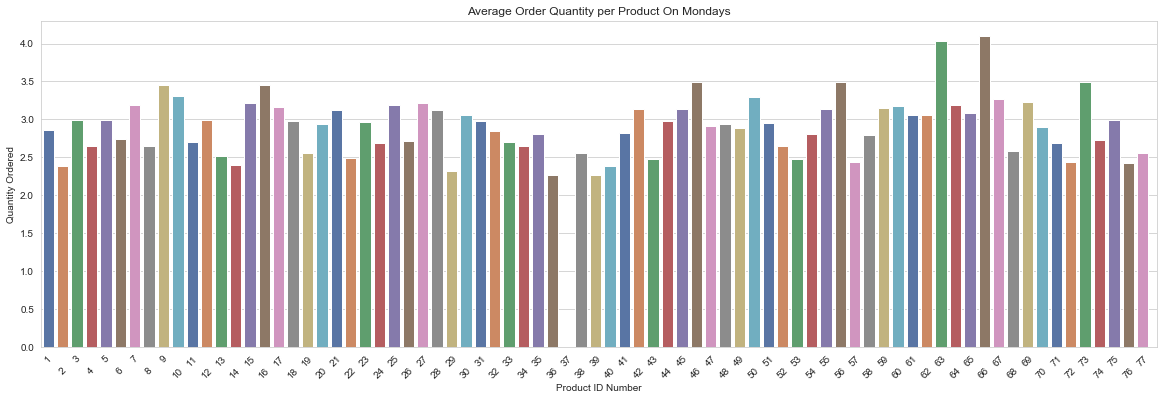

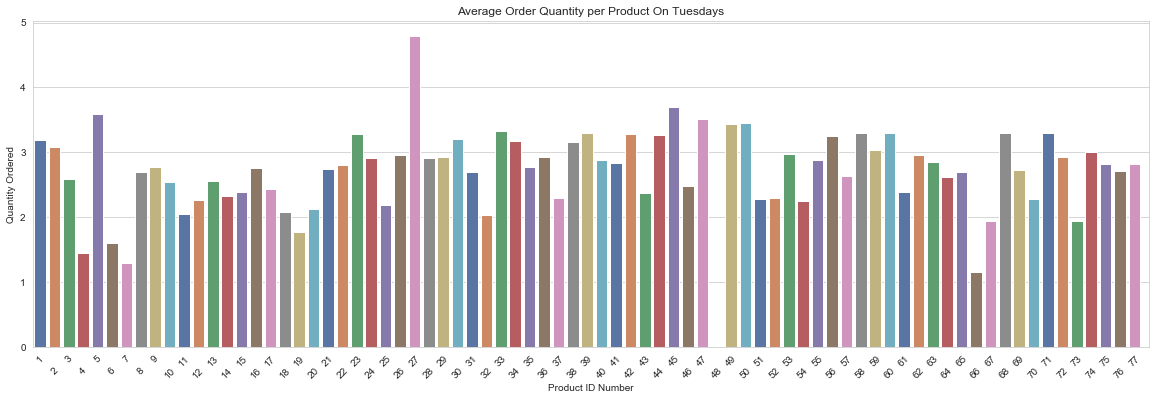

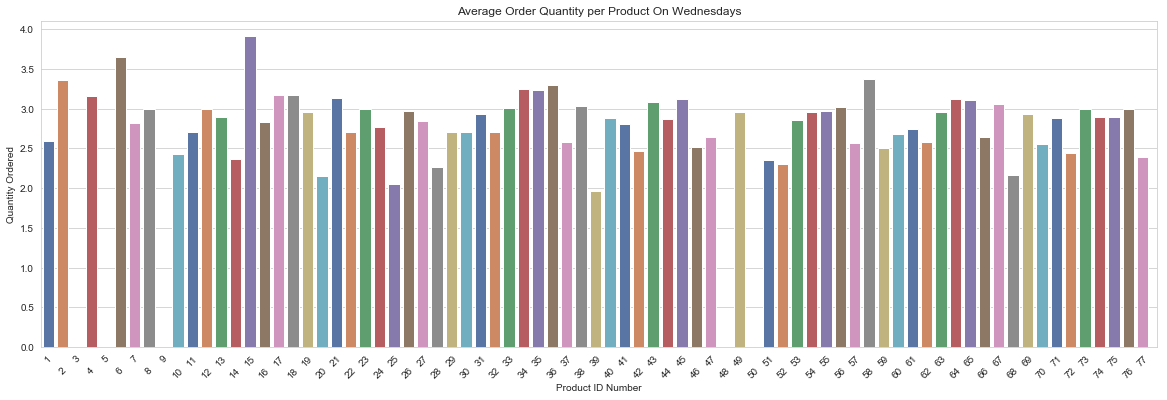

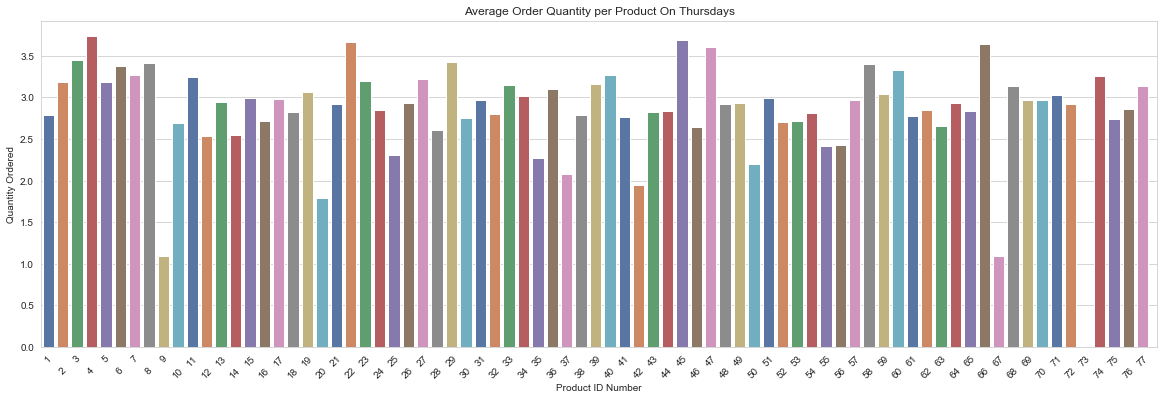

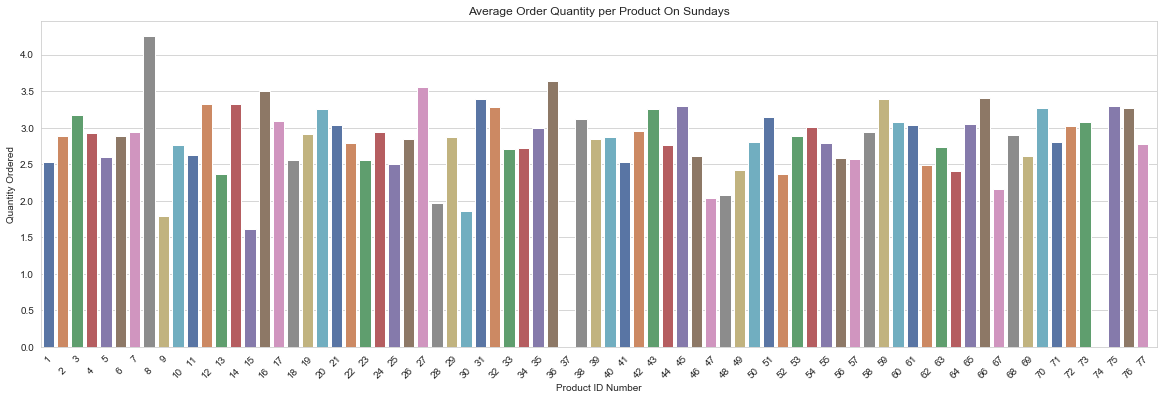

In [25]:
order_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Sunday"] #No orders on Friday or Saturday
for day in order_days:     
    
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)
    sns.barplot(weekday_quantity.ProductId, weekday_quantity[day], palette="deep")
    ax.set_xticks(range(0,78,1))
    ax.set_xticklabels( range(1,78,1), rotation=45)
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(15)
    plt.xlabel("Product ID Number")
    plt.ylabel("Quantity Ordered")
    plt.title(f"Average Order Quantity per Product On {day}s");

The previous graphs illustrate average order quantity per day per product for each order day. The colors do not represent anything and are used to make it easier to read. From this, we can see that certain products have never been ordered on certain days, and that some days vary drastically. Tuesday generally seems to have lower quantities. 

<b>ONE THING TO KEEP IN MIND:</b> The scale is different for each day of the week, depending on the range of order quantities. This can be misleading. 

The following code is written in order to conduct a one sample, two tailed T-test for every product that was ordered for each day of the week, then put it concisely in a dataframe.

In [26]:

pop_means = weekday_quantity.All # Population mean
alpha = .05 # Significance level


p_vals = []
d_o_w = []
significant_or_not = []
difference = []
for day in order_days:
    day_order = order_df.loc[order_df["day_of_week"] == day] #sort by day
    for i in np.arange(1,78): # Sort by product ID
        pop_mean = pop_means[i-1] #Population mean series begins at 0
        a = day_order.loc[day_order["ProductId"]==i].Quantity
        difference.append(a.mean()-pop_mean)
        T, two_tailed_p = stats.ttest_1samp(a=a, popmean=pop_mean)
        p_vals.append(round(two_tailed_p,2))
        d_o_w.append(day)
        if alpha > two_tailed_p/2:
            significant_or_not.append(True)
        else:
            significant_or_not.append(False)    
            
results_df = pd.DataFrame([p_vals, d_o_w, significant_or_not, difference]).transpose()
results_df.columns = ['PVal', "Day", "RejectNull", "Difference"]

/Users/Allie/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/Allie/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/Allie/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Allie/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/Allie/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)


In [27]:
# This cell separates each day into a different dataframe
Monday_Orders = results_df.loc[results_df['Day']=="Monday"]
Tuesday_Orders = results_df.loc[results_df['Day']=="Tuesday"]
Wednesday_Orders = results_df.loc[results_df['Day']=="Wednesday"]
Thursday_Orders = results_df.loc[results_df['Day']=="Thursday"]
Sunday_Orders = results_df.loc[results_df['Day']=="Sunday"]

The product ID column had become the index, so to rename each value to the correct product ID, each day needs to be reindexed 1-77 to align with the correct product:

In [28]:

index=np.arange(1,78)
Monday_Orders.set_index(index, inplace=True)
Tuesday_Orders.set_index(index, inplace=True)
Wednesday_Orders.set_index(index, inplace=True)
Thursday_Orders.set_index(index, inplace=True)
Sunday_Orders.set_index(index, inplace=True)

In [29]:
# This cell selects only the products on each day that had a significant difference in order quantity
Monday_Order_Adjustments = Monday_Orders.loc[Monday_Orders['RejectNull']==True]
Tuesday_Order_Adjustments = Tuesday_Orders.loc[Tuesday_Orders['RejectNull']==True]
Wednesday_Order_Adjustments = Wednesday_Orders.loc[Wednesday_Orders['RejectNull']==True]
Thursday_Order_Adjustments = Thursday_Orders.loc[Thursday_Orders['RejectNull']==True]
Sunday_Order_Adjustments = Sunday_Orders.loc[Sunday_Orders['RejectNull']==True]

In [30]:
weekly_order_adjustments = pd.concat([Monday_Order_Adjustments, Tuesday_Order_Adjustments, Wednesday_Order_Adjustments,
                                     Thursday_Order_Adjustments, Sunday_Order_Adjustments])
weekly_order_adjustments = weekly_order_adjustments.drop(["RejectNull", "PVal"], axis=1)
weekly_order_adjustments.index.name = "ProductId"

In [31]:
weekly_order_adjustments

,Day,Difference
ProductId,,
2,Monday,-0.538837
10,Monday,0.559837
16,Monday,0.422109
25,Monday,0.621101
28,Monday,0.473977
36,Monday,-0.792725
56,Monday,0.48033
67,Monday,0.615105
11,Tuesday,-0.607124


Results: The above dataframe illustrates which products on which days historically have significantly lower or higher order counts, which can help stockists increase or decrease how much of those products are in stock so the company does not have a surplus of perishable food, nor under-stocks which can cause clients to switch to a competitor.  

The null hypothesis was not rejected for most products on most days, however once the data becomes more robust, more analysis can be done. From here, we should check for increases of certain products around holidays, seasons, etc. 

In [35]:
results_df[results_df['PVal'].isnull()].head()

,PVal,Day,RejectNull,Difference
2,NaN,Monday,False,-0.0645816
4,NaN,Monday,False,-0.130441
13,NaN,Monday,False,-0.154288
14,NaN,Monday,False,0.464949
21,NaN,Monday,False,-0.469058


In [33]:
print(np)

<module 'numpy' from '/Users/Allie/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/__init__.py'>


<b>Note:</b> The NaNs in the PVal column signify insufficient data needed to adjust order quanitites. The above dataframe is for observational purposes ONLY and the Product ID has not been reincremented, so will not reflect the true products. 

# Hypothesis 3

$H_{0}$ Products ordered do not change based on region that does the ordering. <br> 
$H_{1}$ Region has an effect on which products are ordered.  

This is a two-tailed t-test.